In [1]:
import re
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
#corpus

from glob import glob
docs = []
file_names = []
for file_name in glob("input_multiple/*.txt"):
 with open(file_name, "rt") as ifd:
    tokens = ifd.read().strip().split()
    docs.append(tokens)
    file_names.append(file_name)
 print(docs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
# NLTK Stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 're', 'edu', 'use', '-pron-',])
#'ningirsu', 'lugal', 'habura', 'lumma', 'dabrum', 'shulmushpa', 'inshushinak', 'lagash', 'ninsuna', 'eshnunna', 'zabshali', 'dumuzi', 'aanepada', 'simurrum', 'tirigan', 'enakale', 'urbillum', 'geshtinanna', 'ephur', 'shin', 'sippar', 'ephur', 'magur', 'shatillu', 'garta', 'alumidatum', 'nushushmar', 'alum', 'gisha', 'ninmarki', 'hendursag', 'guedena', 'hegal', 'erridupizir', 'ninshubur', 'ninhursaga', 'enlil', 'sargon', 'lugalmarda', 'shin', 'kazallu', 'push', 'bashar', 'shishil', 'dada', 'nisaba', 'dudu', 'eanatum', 'enmetena', 'ningal', 'dagan', 'urlumma', 'eridu', 'ibbisin', 'tiwa', 'nagarbi', 'abgal', 'zubi', 'meenlil', 'usarum', 'ilaba', 'annunitum', 'apiak', 'anshan', 'subartum', 'kigal', 'eresh', 'apiak', 'meenili', 'utu', 'magan', 'lugalkiginedudu', 'sharkalisharri', 'shin', 'gunidu', 'bagara', 'tirash', 'ningirsus', 'ebla', 'utu_hegal', 'utuhegal', 'ishkur', 'enanatum', 'baba', 'antasur', 'uruxkar', 'rec', 'gatumdu', 'nergal', 'simashki', 'lugal_uruxkar', 'enki', 'shara', 'uruk', 'nippur', 'mari', 'urukagina', 'numushda', 'inanna', 'naram', 'ishtar', 'kurgal', 'ninlil', 'whose', 'shusin', 'umma', 'nanshe', 'amarsin', 'rimush', 'naram_sin', 'girsu', 'shulgi', 'nammu', 'elam', 'agade', 'parahshum', 'shamash', 'susa', 'kish', 'simanum', 'kutha', 'gunida', 'gursar', 'nanna', 'adab', 'ningursaga', 'gutium', 'sheshgar', 'irnina', 'hibaritum', 'ishtar_annunitum', 'ninhursag', 'sin', 'abzu', 'epa', 'ibgal', 'edam', 'dilmun', 'kinir', 'emah', 'ningar', 'giguna', 'eamma', 'eras', 'manishtushu', 'urtur', 'kindazi', 'emeslam', 'emunusgisa', 'ninkununa', 'gipar', 'karzida', 'pasira', 'etemeniguru', 'geshtinana', 'armanum', 'euphrates', 'esar', 'amanus', 'enlil', 'puzur', 'eninsar', 'nissaba', 'rigmushdan', 'etunigaana', 'eduruenki', 'hiritum', 'lagardingirigi', 'kirilum', 'ekur', 'eninnu',' eada', 'eengur', 'imsag', 'zulum', 'igalim', 'eshdugru', 'ahush', 'ninsar', 'shin', 'lugalemush', 'urningirsu', 'enmezianna', 'kian', 'adad', 'eras'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 

In [4]:
# Convert to list
data = list(docs)
print(data)

[['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['the', 'Esar', 'Mebalak', '551', 'king', 'of', 'Adab'], ['to', 'the', 'goddess', 'Inanna', 'Aka', 'king', 'of', 'Umma'], ['Esar', 'Barahenidu'], ['the', 'Esar', 'Lugaldalu', 'king', 'of', 'Adab'], ['the', 'Esar', 'Lumma'], ['Lumma', 'the', 'ensigar'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensi', 'of', 'Adab', 'who', 'built', 'the', 'Emah'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensigar', 'of', 'Adab', 'built', 'the', 'Emah', 'for', 'her', 'buried', 'foundation', 'deposits', 'below', 'its', 'base'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensigar', 'of', 'Adab', 'built', 'the', 'Emah', 'for', 'her', 'buried', 'foundation', 'deposits', 'below', 'its', 'base'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'ensigar', 'of', 'Adab', 'built', 'the', 'Emah', 'for', 'her', 'buried', 'foundation', 'deposits', 'below', 'its', 'base'], ['for', 'the', 'goddess', 'Digirmah', 'Eiginimpae', 'en

In [5]:
#Tokenize and Clean-up

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'esar', 'mebalak', 'king', 'of', 'adab']]


In [6]:
#lemmatize

from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(data_words)

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/meganlewis/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['the', 'esar', 'mebalak', 'king', 'of', 'adab']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['esar', 'mebalak', 'king', 'adab']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adab', 1), ('esar', 1), ('king', 1), ('mebalak', 1)]]

In [12]:
# step 12

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=500,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# step 13

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
for i, row in enumerate(doc_lda):
    print(file_names[i], row[0])

[(0,
  '0.261*"king" + 0.119*"build" + 0.114*"mighty" + 0.079*"land" + '
  '0.078*"temple" + 0.060*"beloved" + 0.052*"sumer" + 0.050*"akkad" + '
  '0.046*"nanna" + 0.035*"son"'),
 (1,
  '0.061*"establish" + 0.023*"numushda" + 0.023*"tower" + 0.016*"city" + '
  '0.015*"held_back" + 0.015*"irnina" + 0.014*"hibaritum" + '
  '0.011*"northern_side" + 0.011*"weight" + 0.011*"standardize"'),
 (2,
  '0.263*"goddess" + 0.177*"lady" + 0.132*"shulgi" + 0.086*"inanna" + '
  '0.052*"life" + 0.051*"nanshe" + 0.025*"offering" + 0.024*"dedicated" + '
  '0.022*"ningal" + 0.014*"eduranki"'),
 (3,
  '0.073*"goddess" + 0.056*"dedicate" + 0.037*"sin" + 0.031*"ninhursaga" + '
  '0.028*"ninhursag" + 0.027*"make" + 0.026*"kish" + 0.026*"priest" + '
  '0.024*"forth" + 0.020*"giparku"'),
 (4,
  '0.279*"enlil" + 0.275*"god" + 0.141*"lord" + 0.079*"name" + 0.067*"king" + '
  '0.039*"firstborn" + 0.033*"etemniguru" + 0.031*"impetuous_calf" + '
  '0.009*"uruk" + 0.007*"alter"'),
 (5,
  '0.038*"governor" + 0.028*"ci

input_multiple/E2.1.1.5.txt [(0, 0.2910749), (2, 0.040148422), (3, 0.0111167), (4, 0.18872385), (5, 0.29465488), (6, 0.013003253), (7, 0.017065743), (8, 0.0105624), (9, 0.060741223), (10, 0.019195057), (11, 0.014557297), (13, 0.026974548)]
input_multiple/E2.1.1.6.txt [(0, 0.07937228), (1, 0.0193228), (2, 0.021889169), (3, 0.025589785), (4, 0.30971906), (5, 0.31634262), (6, 0.0398306), (7, 0.040519506), (8, 0.10052585), (9, 0.012807396), (10, 0.02394516)]
input_multiple/E2.1.1.7.txt [(0, 0.11164339), (1, 0.025402643), (2, 0.010505151), (4, 0.19653276), (5, 0.3560326), (6, 0.07562792), (7, 0.052100364), (8, 0.13489175), (9, 0.016287938)]
input_multiple/E2.1.1.8.txt [(0, 0.18186577), (2, 0.019188622), (4, 0.1305285), (5, 0.27810207), (6, 0.049719635), (8, 0.16912922), (9, 0.030076435), (10, 0.055567004), (11, 0.053638775), (13, 0.012892273)]
input_multiple/E2.1.1.9.txt [(0, 0.15535013), (2, 0.016973354), (3, 0.043182082), (4, 0.23900785), (5, 0.28828707), (6, 0.043979652), (8, 0.11011563)

input_multiple/E3:2.1.1.11 copy 85.txt [(0, 0.39617103), (2, 0.024522956), (4, 0.3949759), (5, 0.013180576), (7, 0.010423884), (9, 0.09499927), (10, 0.011736427), (13, 0.016476255)]
input_multiple/E3:2.1.1.11 copy 86.txt [(0, 0.39617187), (2, 0.024522956), (4, 0.39497486), (5, 0.013180576), (7, 0.010423884), (9, 0.09499951), (10, 0.01173643), (13, 0.016476255)]
input_multiple/E3:2.1.1.11 copy 87.txt [(0, 0.39617145), (2, 0.024522956), (4, 0.3949754), (5, 0.013180576), (7, 0.010423884), (9, 0.094999366), (10, 0.011736428), (13, 0.016476255)]
input_multiple/E3:2.1.1.11 copy 88.txt [(0, 0.39617106), (2, 0.024522956), (4, 0.39497596), (5, 0.013180576), (7, 0.010423884), (9, 0.0949992), (10, 0.011736428), (13, 0.016476255)]
input_multiple/E3:2.1.1.11 copy 89.txt [(0, 0.39617085), (2, 0.024522956), (4, 0.39497626), (5, 0.013180576), (7, 0.010423884), (9, 0.09499914), (10, 0.011736428), (13, 0.016476255)]
input_multiple/E3:2.1.1.11 copy 9.txt [(0, 0.39617124), (2, 0.024522956), (4, 0.3949757)

input_multiple/E3:2.1.1.4 copy 17.txt [(0, 0.59207606), (2, 0.031536553), (4, 0.14231072), (5, 0.016950237), (6, 0.08171435), (7, 0.0134051265), (9, 0.047712177), (10, 0.015077702), (11, 0.011434745), (13, 0.021188485)]
input_multiple/E3:2.1.1.4 copy 18.txt [(0, 0.5920847), (2, 0.03153655), (4, 0.14230204), (5, 0.016950237), (6, 0.08171434), (7, 0.013405126), (9, 0.047712173), (10, 0.015077701), (11, 0.011434744), (13, 0.021188483)]
input_multiple/E3:2.1.1.4 copy 19.txt [(0, 0.59207964), (2, 0.031536553), (4, 0.14230712), (5, 0.016950237), (6, 0.08171435), (7, 0.0134051265), (9, 0.047712177), (10, 0.015077702), (11, 0.011434745), (13, 0.021188485)]
input_multiple/E3:2.1.1.4 copy 2.txt [(0, 0.59207684), (2, 0.031536553), (4, 0.1423099), (5, 0.016950237), (6, 0.08171435), (7, 0.0134051265), (9, 0.047712177), (10, 0.015077702), (11, 0.011434745), (13, 0.021188485)]
input_multiple/E3:2.1.1.4 copy 20.txt [(0, 0.5920776), (2, 0.03153655), (4, 0.14230914), (5, 0.016950237), (6, 0.08171434), (

input_multiple/E3:2.1.2.9 copy 2.txt [(0, 0.48988995), (2, 0.2802172), (4, 0.041546486), (5, 0.010313483), (9, 0.07253562), (11, 0.052878056), (13, 0.012892272)]
input_multiple/E3:2.1.2.9 copy 3.txt [(0, 0.48988757), (2, 0.2802172), (4, 0.041546587), (5, 0.010313482), (9, 0.07253561), (11, 0.052880287), (13, 0.012892271)]
input_multiple/E3:2.1.2.9 copy 4.txt [(0, 0.48988694), (2, 0.2802172), (4, 0.041546613), (5, 0.010313482), (9, 0.07253561), (11, 0.052880887), (13, 0.012892271)]
input_multiple/E3:2.1.2.9 copy.txt [(0, 0.4898894), (2, 0.2802172), (4, 0.041546535), (5, 0.010313482), (9, 0.07253561), (11, 0.052878495), (13, 0.012892271)]
input_multiple/E3:2.1.2.9.txt [(0, 0.48988765), (2, 0.2802172), (4, 0.041546583), (5, 0.010313483), (9, 0.07253562), (11, 0.05288023), (13, 0.012892272)]
input_multiple/E3:2.1.3.1 copy 10.txt [(0, 0.29544553), (2, 0.022068935), (4, 0.30982357), (5, 0.011861591), (9, 0.14215192), (10, 0.010575108), (13, 0.16493288)]
input_multiple/E3:2.1.3.1 copy 11.txt 

input_multiple/E3:2.1.4.19 copy.txt [(0, 0.45303217), (2, 0.020061389), (4, 0.19325896), (5, 0.010782577), (9, 0.03195575), (10, 0.057103135), (12, 0.13975145), (13, 0.058962245)]
input_multiple/E3:2.1.4.19.txt [(0, 0.45300493), (2, 0.020061389), (4, 0.19329287), (5, 0.010782577), (9, 0.03195128), (10, 0.0570991), (12, 0.13975331), (13, 0.058962245)]
input_multiple/E3:2.1.4.2.txt [(0, 0.16653825), (1, 0.041168366), (2, 0.016973354), (3, 0.043182086), (4, 0.03628117), (5, 0.5468504), (9, 0.064161584), (10, 0.046597287), (13, 0.011403899)]
input_multiple/E3:2.1.4.20 copy.txt [(0, 0.41505924), (2, 0.04919732), (3, 0.057665043), (4, 0.1791609), (6, 0.047646765), (9, 0.0293177), (12, 0.12809709), (13, 0.054045852)]
input_multiple/E3:2.1.4.20.txt [(0, 0.41506293), (2, 0.04929773), (3, 0.05756462), (4, 0.17916204), (6, 0.047646765), (9, 0.0293076), (12, 0.1281024), (13, 0.054045852)]
input_multiple/E3:2.1.4.21 copy.txt [(0, 0.53895116), (2, 0.014709179), (4, 0.13706623), (9, 0.05737734), (12,

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.508664003425206

Coherence Score:  0.404084972904761


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/meganlewis/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.305381 -0.296269       1        1  26.682600
4      0.342716  0.079798       2        1  12.343821
9      0.126186  0.222540       3        1  11.845883
5     -0.111575 -0.067525       4        1   8.628645
10     0.088546  0.159032       5        1   6.763223
2     -0.104167 -0.083024       6        1   5.577327
11    -0.058069 -0.198909       7        1   4.752336
13    -0.040070  0.052283       8        1   4.508126
7     -0.066916  0.035751       9        1   3.559239
12    -0.055121  0.078228      10        1   3.436897
1     -0.086017  0.052820      11        1   3.284454
3     -0.127441 -0.013298      12        1   3.053649
8     -0.123971 -0.085874      13        1   2.875058
6     -0.089482  0.064448      14        1   2.688736, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
2     Default  2698.000000              king  2698.000000  30.0000  30.0000
63    Default  1191.000000             enlil  1191.000000  29.0000  29.0000
22    Default  1580.000000               god  1580.000000  28.0000  28.0000
316   Default   899.000000               man   899.000000  27.0000  27.0000
5     Default   586.000000           goddess   586.000000  26.0000  26.0000
12    Default  1098.000000             build  1098.000000  25.0000  25.0000
141   Default  1055.000000            mighty  1055.000000  24.0000  24.0000
186   Default   603.000000              lord   603.000000  23.0000  23.0000
1336  Default   400.000000           quarter   400.000000  22.0000  22.0000
42    Default   841.000000              land   841.000000  21.0000  21.0000
108   Default   326.000000             canal   326.000000  20.0000  20.0000
200   Default   343.000000              lady   343.000000  19.0000  19.0000
95    Default   721.000000            temple   721.000000  18.0000  18.0000
140   Default   310.000000               may   310.000000  17.0000  17.0000
1861  Default   255.000000            shulgi   255.000000  16.0000  16.0000
1969  Default   236.000000           amarsin   236.000000  15.0000  15.0000
106   Default   555.000000           beloved   555.000000  14.0000  14.0000
28    Default   340.000000              name   340.000000  13.0000  13.0000
332   Default   237.000000          ningirsu   237.000000  12.0000  12.0000
164   Default   485.000000             sumer   485.000000  11.0000  11.0000
1687  Default   459.000000             akkad   459.000000  10.0000  10.0000
2041  Default   169.000000            shusin   169.000000   9.0000   9.0000
215   Default   427.000000             nanna   427.000000   8.0000   8.0000
783   Default   255.000000              call   255.000000   7.0000   7.0000
1970  Default   165.000000  nippur_supporter   165.000000   6.0000   6.0000
331   Default   189.000000            lagash   189.000000   5.0000   5.0000
205   Default   148.000000             great   148.000000   4.0000   4.0000
6     Default   167.000000            inanna   167.000000   3.0000   3.0000
367   Default   125.000000            battle   125.000000   2.0000   2.0000
113   Default   120.000000           destroy   120.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
27    Topic14    75.361885          mountain    76.208611   3.6049  -2.5141
228   Topic14    46.739994           capture    47.586716   3.5981  -2.9918
234   Topic14    31.708372            return    32.555099   3.5897  -3.3798
398   Topic14    26.976049            spouse    27.822771   3.5852  -3.5415
397   Topic14    21.783329              ship    22.630051   3.5780  -3.7553
369   Topic14    17.435072              gate    18.281799   3.5687  -3.9779
735   Topic14    14.345710              year    15.192433   3.5588  -4.1730
233   Topic14    11.370135    precious_metal    12.21

for doc in corpus:
   print(lda_model.get_document_topics(doc))

for text, doc in zip(texts, corpus):
   print("{}\n{}\n\n".format(text, lda_model.get_document_topics(doc)))

print(lda_model.print_topics(num_topics=6, num_words=20))

In [16]:
#compute coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=100, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

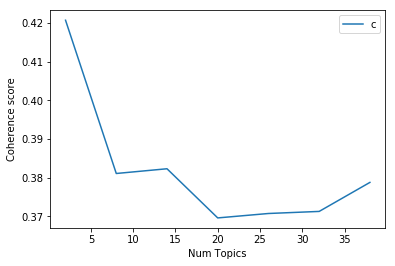

In [18]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4207
Num Topics = 8  has Coherence Value of 0.3811
Num Topics = 14  has Coherence Value of 0.3823
Num Topics = 20  has Coherence Value of 0.3696
Num Topics = 26  has Coherence Value of 0.3708
Num Topics = 32  has Coherence Value of 0.3713
Num Topics = 38  has Coherence Value of 0.3788


In [20]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.070*"king" + 0.055*"build" + 0.035*"god" + 0.032*"temple" + 0.031*"canal" '
  '+ 0.030*"land" + 0.024*"mighty" + 0.021*"enlil" + 0.019*"sumer" + '
  '0.019*"man"'),
 (1,
  '0.023*"god" + 0.023*"king" + 0.013*"enlil" + 0.012*"city" + 0.012*"battle" '
  '+ 0.011*"land" + 0.011*"build" + 0.010*"governor" + 0.010*"goddess" + '
  '0.009*"naramsin"'),
 (2,
  '0.115*"king" + 0.054*"build" + 0.044*"mighty" + 0.042*"god" + 0.037*"enlil" '
  '+ 0.037*"land" + 0.032*"beloved" + 0.032*"temple" + 0.031*"man" + '
  '0.031*"sumer"'),
 (3,
  '0.034*"king" + 0.022*"goddess" + 0.022*"may" + 0.021*"god" + 0.017*"man" + '
  '0.016*"land" + 0.012*"mighty" + 0.011*"enlil" + 0.010*"build" + '
  '0.009*"establish"'),
 (4,
  '0.077*"king" + 0.027*"mighty" + 0.026*"god" + 0.024*"land" + 0.020*"enlil" '
  '+ 0.017*"canal" + 0.016*"quarter" + 0.016*"goddess" + 0.015*"make" + '
  '0.014*"beloved"'),
 (5,
  '0.069*"enlil" + 0.063*"god" + 0.057*"king" + 0.027*"mighty" + 0.026*"man" + '
  '0.019*"lord" + 0.

In [21]:
#Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=file_names)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'File_Names']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,File_Names
0,0,11.0,0.8313,"king, god, enlil, land, may, mighty, city, god...",input_multiple/E1.1.2.1 copy.txt
1,1,11.0,0.8313,"king, god, enlil, land, may, mighty, city, god...",input_multiple/E1.1.2.1.txt
2,2,4.0,0.5221,"king, mighty, god, land, enlil, canal, quarter...",input_multiple/E1.1.2.2.txt
3,3,5.0,0.7147,"enlil, god, king, mighty, man, lord, quarter, ...",input_multiple/E1.1.3.1.txt
4,4,2.0,0.8371,"king, build, mighty, god, enlil, land, beloved...",input_multiple/E1.1.4.1.txt
5,5,11.0,0.3719,"king, god, enlil, land, may, mighty, city, god...",input_multiple/E1.1.5.1.txt
6,6,12.0,0.3801,"god, enlil, son, king, ningirsu, goddess, buil...",input_multiple/E1.1.5.2.txt
7,7,7.0,0.6847,"build, god, goddess, ningirsu, king, land, can...",input_multiple/E1.1.7.1.txt
8,8,7.0,0.9163,"build, god, goddess, ningirsu, king, land, can...",input_multiple/E1.1.7.2 copy 10.txt
9,9,7.0,0.9163,"build, god, goddess, ningirsu, king, land, can...",input_multiple/E1.1.7.2 copy 2.txt


In [25]:
#save dominant topics to excel file
writer = ExcelWriter('dominant_topic.xlsx')
df_dominant_topic.to_excel(writer,'dominant_topic',index=False)
writer.save()

In [23]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "File_Names"]

# Show
sent_topics_sorted.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,File_Names
0,0.0,0.9973,"king, build, god, temple, canal, land, mighty,...",input_multiple/E3:2.1.1.21.txt
1,1.0,0.9961,"god, king, enlil, city, battle, land, build, g...",input_multiple/E2.1.4.6 copy.txt
2,2.0,0.9834,"king, build, mighty, god, enlil, land, beloved...",input_multiple/E3:2.1.4.13.txt
3,3.0,0.9967,"king, goddess, may, god, man, land, mighty, en...",input_multiple/E3:2.1.1.20.txt
4,4.0,0.9788,"king, mighty, god, land, enlil, canal, quarter...",input_multiple/E3:2.1.5.1.txt


In [26]:
#save representative documents to excel file
writer = ExcelWriter('representative_document.xlsx')
sent_topics_sorted.to_excel(writer,'representative_document',index=False)
writer.save()